In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_train.csv' .
#! cp '/content/drive/My Drive/tweet-sentiment-extraction/preprocessed_test.csv' .
! cp '/content/drive/My Drive/tweet-sentiment-extraction/train.csv' .
! cp '/content/drive/My Drive/tweet-sentiment-extraction/test.csv' .

In [ ]:
#train_df = pd.read_csv('preprocessed_train.csv')
#test_df = pd.read_csv('preprocessed_test.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.shape,test_df.shape

((27481, 4), (3534, 3))

In [ ]:
train_df.sample(10)

,textID,text,selected_text,sentiment
4714,e4db70af7f,_berra happy bday stevie bee...and if u want f...,y babies r the best!,positive
20556,def0c6563e,Goin to work....,Goin to work....,neutral
25906,8bd6e048bd,Its like I had a power nap.,Its like I had a power nap.,neutral
1207,993ed46c7e,It`s teddy-chucking time,It`s teddy-chucking time,negative
24459,2c8f6efd46,I want to SOOOOOOO BAD!!!,I want to SOOOOOOO BAD!!!,neutral
8389,b34b83c44e,"is really, really bored... I guess I will go t...","is really, really bored...",negative
15919,d31b1fafb0,o **** i just accidentally listened to rick ross,****,negative
27461,c37b979e7e,again thanks to my dear neighboor who also ga...,thanks,positive
21373,29fa1f6ee0,you`re just unhappy to return to occupying th...,you`re just unhappy,negative
9766,307b9d7151,It starts again June 14,It starts again June 14,neutral


In [ ]:
test_df.sample(5)

,textID,text,sentiment
224,be33b5cb9a,Again working on the internet shop ... don`t t...,neutral
2073,25f1991c36,D: But it is making people unhappy and I dun ...,negative
394,cc29d748cb,_a_michael It doesn`t look like you`re tired i...,neutral
540,27c4e1f089,"I am sending healthy, healing thoughts in ...",positive
2345,1cf039efa9,walked home in the rain.,neutral


In [ ]:
train_df.isnull().sum(),test_df.isnull().sum()

(textID           0
 text             1
 selected_text    1
 sentiment        0
 dtype: int64, textID       0
 text         0
 sentiment    0
 dtype: int64)

In [ ]:
train_df[train_df.text.isna()]


,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [ ]:
train_df.dropna(axis=0,inplace=True)
train_df.shape,test_df.shape

((27480, 4), (3534, 3))

In [ ]:
train_df.duplicated().sum(),test_df.duplicated().sum()

(0, 0)

In [ ]:
train_df.sample(7)

,textID,text,selected_text,sentiment
141,997a62f83f,These kids are terrible! If I was in Good Evan...,terrible!,negative
9838,fcc9e4ec6f,what time is our conference call??,what time is our conference call??,neutral
7107,64d7ee6da7,yo wake your **** up and go to work go get ...,ick dont,negative
1507,06b613e3c6,so sad u cancelled silverstone show better s...,sad,negative
10330,3723ddd113,Trying to get this swimmer`s ear to go away!!,Trying to get this swimmer`s ear to go away!!,neutral
7476,482a27ec9b,the start of my day was finding a lump on my b...,apparently its nothing! fewfffff! bloodtests s...,neutral
14462,bf4ba75b52,Thanks for the follow my new Twitpeeps!,Thanks fo,negative


In [ ]:
train_df['text'] = train_df['text'].progress_apply(lambda x : str(x).lower())
train_df['selected_text'] = train_df['selected_text'].progress_apply(lambda x : str(x).lower())

In [ ]:
train_df.sample(10)

,textID,text,selected_text,sentiment
17345,1cd56df654,a bedtime story pls....,a bedtime story pls....,neutral
14137,1d50edc9d2,"happy mother`s day! going to cook something, t...",happy mother`s day!,positive
26775,06c9fdb980,maybe going to the movies later? ik ****,maybe going to the movies later? ik ****,neutral
20125,03d09e69c8,"congrats, dreps! and good luck sa interview!","congrats,",positive
11181,2e8d232114,"for some strange reason, `paranoid` sounds lik...",love,positive
4496,05a555d96d,till then ..ice cream!,till then ..ice cream!,neutral
20101,336d79d2d0,good night you twitter people,good night you twitter people,positive
8816,972394bef4,using my old phone! gosh! i miss this phone!,miss,negative
14307,1ca884fc2c,c-news wasn`t as bad as i expected... could ha...,better..,positive
6223,1ebeec2fbf,*waves to make it all ok again*,*waves to make it all ok again*,positive


In [ ]:
train_df[train_df.text=='']

,textID,text,selected_text,sentiment


In [ ]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',add_prefix_space=True)
tokenizer.encode(' hello world'),tokenizer.encode('hello world')

([0, 20760, 232, 2], [0, 20760, 232, 2])

In [ ]:
tokenizer.encode('positive'),tokenizer.encode('negative'),tokenizer.encode('neutral')

([0, 1313, 2], [0, 2430, 2], [0, 7974, 2])

In [ ]:
tokenizer.decode([0,1313,2])

'<s> positive</s>'

In [ ]:
train_df['sentiment'].value_counts()/274.8

neutral     40.454876
positive    31.229985
negative    28.315138
Name: sentiment, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val , y_train , y_val = train_test_split(train_df[['text','sentiment']],train_df['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

((21984, 2), (5496, 2), (21984,), (5496,))

In [ ]:
x_train['sentiment'].value_counts()/ (x_train.shape[0]/100), x_val['sentiment'].value_counts()/ (x_val.shape[0]/100)

(neutral     40.397562
 positive    31.359170
 negative    28.243268
 Name: sentiment, dtype: float64, neutral     40.684134
 positive    30.713246
 negative    28.602620
 Name: sentiment, dtype: float64)

**input_ids** - Indices of input sequence tokens in the vocabulary.

The input ids are often the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model.

**attention_mask** – Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:

1 for tokens that are not masked,

0 for tokens that are maked.

The attention mask is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.


In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))
jaccard('i am a vad guy','i am    a    vad    guy')

1.0

In [ ]:
MAX_LEN=128
count = x_train.shape[0]
input_ids = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens = np.zeros((count,MAX_LEN),dtype='int32')
toks_all = []

In [ ]:
count=0
for i,each in tqdm(enumerate(x_train.values)):
  val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids[i] = val['input_ids']
  attention_mask[i] = val['attention_mask']
  text1 = " "+" ".join(each[0].split())
  text2 = " ".join(y_train.values[i].split())
  #finding the start index 
  idx = text1.find(text2)
  chars = np.zeros((len(text1)))
  chars[idx:idx+len(text2)]=1
  if text1[idx-1]==' ':
    chars[idx-1] = 1


  enc = tokenizer.encode(text1) 
  offsets = []; idx=0
  for t in enc:
    w=tokenizer.decode([t])
    offsets.append((idx,idx+len(w)))
    idx += len(w)

  toks = []
  for c,(a,b) in enumerate(offsets):
    sm = np.sum(chars[a:b])
    if sm>0:
      toks.append(c)
  toks_all.append(toks)    
  if len(toks)>0:
    count+=1
    start_tokens[i,(toks[0])+1] = 1
    end_tokens[i,(toks[-1])+1] = 1
  

21984it [00:25, 860.40it/s]


In [ ]:
input_ids.shape,attention_mask.shape,start_tokens.shape,end_tokens.shape

((21984, 128), (21984, 128), (21984, 128), (21984, 128))

In [ ]:
#Visualize the results
import random

for _ in range(35,50):
  i = random.randint(0,x_train.shape[0])
  print(x_train.iloc[i]['text'])
  print(y_train.values[i])
  print([tokenizer.decode([x]) for x in tokenizer.encode(x_train.iloc[i]['text'])])
  print('Input ids',input_ids[i])
  print('attention mask',attention_mask[i])
  print('Start tokens',start_tokens[i])
  print('end   Tokens',end_tokens[i])
  print('Toks',toks_all[i])
  a = np.argmax(start_tokens[i])
  b=np.argmax(end_tokens[i])
  print(a,b)
  text1 = " "+" ".join(x_train.iloc[i]['text'].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[a:b+1])
  print(st)
  print('*'*50)

my street fighter iv skills are lacking, can`t beat seth on easy.
lacking,
['<s>', ' my', ' street', ' fighter', ' iv', ' skills', ' are', ' lacking', ',', ' can', '`', 't', ' beat', ' set', 'h', ' on', ' easy', '.', '</s>']
Input ids [    0   127  2014  7251 40436  2417    32 12622     6    64 12905    90
  1451   278   298    15  1365     4     2     2  2430     2     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [ ]:
MAX_LEN=128
count = y_val.shape[0]
input_ids_val = np.zeros((count,MAX_LEN),dtype='int32')
attention_mask_val = np.zeros((count,MAX_LEN),dtype='int32')
start_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')
end_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')

In [ ]:
count=0
for i,each in tqdm(enumerate(x_val.values)):
  val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
  input_ids_val[i] = val['input_ids']
  attention_mask_val[i] = val['attention_mask']
  text1 = " "+" ".join(each[0].split())
  text2 = " ".join(y_val.values[i].split())
  #finding the start index 
  idx = text1.find(text2)
  chars = np.zeros((len(text1)))
  chars[idx:idx+len(text2)]=1
  if text1[idx-1]==' ':
    chars[idx-1] = 1


  enc = tokenizer.encode(text1) 
  offsets = []; idx=0
  for t in enc:
    w=tokenizer.decode([t])
    offsets.append((idx,idx+len(w)))
    idx += len(w)

  toks = []
  for c,(a,b) in enumerate(offsets):
    sm = np.sum(chars[a:b])
    if sm>0:
      toks.append(c)
  toks_all.append(toks)    
  if len(toks)>0:
    count+=1
    start_tokens_val[i,(toks[0])+1] = 1
    end_tokens_val[i,(toks[-1])+1] = 1
  

5496it [00:06, 894.05it/s]


In [ ]:
input_ids_val.shape,attention_mask_val.shape,start_tokens_val.shape,end_tokens_val.shape

((5496, 128), (5496, 128), (5496, 128), (5496, 128))

In [ ]:
#Visualize the results
import random

for _ in range(35,50):
  i = random.randint(0,x_val.shape[0])
  print(x_val.iloc[i]['text'])
  print(y_val.values[i])
  print([tokenizer.decode([x]) for x in tokenizer.encode(x_val.iloc[i]['text'])])
  print('Input ids',input_ids[i])
  print('attention mask',attention_mask[i])
  print('Start tokens',start_tokens[i])
  print('end   Tokens',end_tokens[i])
  #print('Toks',toks_all[i])
  a = np.argmax(start_tokens_val[i])
  b=np.argmax(end_tokens_val[i])
  print(a,b)
  text1 = " "+" ".join(x_val.iloc[i]['text'].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc[a:b+1])
  print(st)
  print('*'*50)

 i feel sorry for your nails. lol... i feel fine thank you
i feel sorry for your nails. lol... i feel fine thank you
['<s>', ' i', ' feel', ' sorry', ' for', ' your', ' nails', '.', ' lol', '...', ' i', ' feel', ' fine', ' thank', ' you', '</s>']
Input ids [    0    16  1372    14   326  4822    64 12905    90  1874 10709    98
    79    64  6297    19   162  1437   295   219   857   298 43555   895
   328     2     2  7974     2     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1 

In [ ]:
from transformers import TFRobertaForQuestionAnswering
roberta = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForQuestionAnswering: ['lm_head']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Softmax,Dense,Activation,Dropout

In [ ]:
input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
start_scores,end_scores = roberta(input1,attention_mask = input2)
dense1 = Dense(units=MAX_LEN,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
drop1 = Dropout(0.4)(dense1)
dense11 = Dense(units=MAX_LEN,activation='relu',name='dense11',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(drop1)
softmax1 = Activation('softmax')(dense11)
dense2 = Dense(units=MAX_LEN,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
drop2 = Dropout(0.4)(dense2)
dense22 = Dense(units=MAX_LEN,activation='relu',name='dense22',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(drop2)
softmax2 = Activation('softmax')(dense22)

In [ ]:
model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_id (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_question_answeri ((None, 128), (None, 124647170   input_id[0][0]                   
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 128)          16512       tf_roberta_for_questio

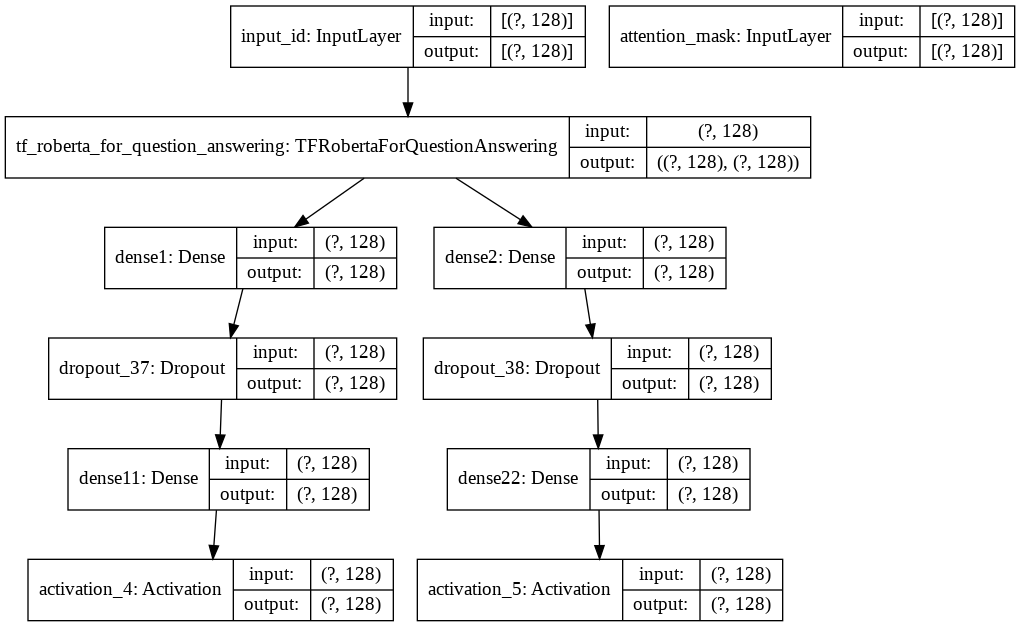

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

In [ ]:
! rm -r '/content/checkpt'
! rm -r '/content/tensorboard_logs1'

rm: cannot remove '/content/checkpt': No such file or directory


In [ ]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

In [ ]:
%load_ext tensorboard
import datetime
import os
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2,verbose=3,min_lr = 1e-9)
log_dir= os.path.join("tensorboard_logs1" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
! mkdir  'checkpt1'
file_path = os.path.join('checkpt1/model1.hdf5')
checkpt_save = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,save_weights_only=True,monitor='val_loss',save_best_only=True,verbose=1)
callbacks=[tensorboard_callback,checkpt_save]

mkdir: cannot create directory ‘checkpt1’: File exists


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

In [ ]:
#model.fit(input_data,output_data,epochs=10,batch_size=128,validation_data=val_data,callbacks=callbacks)
model.fit(train_dataset,epochs=15,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/15
  1/687 [..............................] - ETA: 0s - loss: 9.7343 - activation_4_loss: 4.8389 - activation_5_loss: 4.8903WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
687/687 [==============================] - ETA: 0s - loss: 6.9452 - activation_4_loss: 2.5454 - activation_5_loss: 4.3947
Epoch 00001: val_loss improved from inf to 5.64399, saving model to checkpt1/model1.hdf5
687/687 [==============================] - 384s 559ms/step - loss: 6.9452 - activation_4_loss: 2.5454 - activation_5_loss: 4.3947 - val_loss: 5.6440 - val_activation_4_loss: 1.9423 - val_activation_5_loss: 3.6966
Epoch 2/15
687/687 [==============================] - ETA: 0s - loss: 5.4642 - activation_4_loss: 1.9017 - activation_5_loss: 3.5575
Epoch 00002: val_loss improved fr

In [ ]:
! cp  -r '/content/checkpt1' '/content/drive/My Drive/tweet-sentiment-extraction'

In [ ]:
stop

NameError: ignored

In [ ]:
#tf.keras.backend.clear_session()
#%tensorboard --logdir $log_dir --port 0

In [ ]:
model.load_weights('checkpt/model.hdf5')
start_pred_train , end_pred_train = model.predict((input_data))
start_pred_train.shape,end_pred_train.shape

In [ ]:
strt =[]
end=[]
pred_values = []
for i in tqdm(range(start_pred_train.shape[0])):
  s = np.argmax(start_pred_train[i,])
  e = np.argmax(end_pred_train[i,])
  text1 = " "+" ".join(x_train['text'][i].split())
  enc = tokenizer.encode(text1)
  st = tokenizer.decode(enc.ids[s-1:e])
  pred_values.append(st)
  #s = tf.math.argmax(start_pred_train[i],axis=0).numpy()
  #e = tf.math.argmax(end_pred_train[i],axis=0).numpy()
  #strt.append(s)
  #end.append(e)

len(strt),len(end)  

In [ ]:
'''
for i in tqdm(range(len(strt))):
  index1 = strt[i]
  index2 = end[i] +1
  pred = input_ids[i][index1:index2]
  mystring = tokenizer.decode(pred)
  pred_values.append(mystring)

actual_values = (y_train.values)
len(actual_values),len(pred_values) '''

In [ ]:
x_train

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
scores=[]
for i in tqdm(range(len(actual_values))):
  scores.append(jaccard(actual_values[i],pred_values[i]))

In [ ]:
print('jaccard score for training data:',np.mean(scores))

In [ ]:
stop

In [ ]:
start_pred_val , end_pred_val = model.predict((val))
print(start_pred_val.shape,end_pred_val.shape)
strt_val =[]
end_val=[]
for i in tqdm(range(start_pred_val.shape[0])):
  s = tf.math.argmax(start_pred_val[i],axis=0).numpy()
  e = tf.math.argmax(end_pred_val[i],axis=0).numpy()
  strt_val.append(s)
  end_val.append(e)
print(len(strt_val),len(end_val)) 

pred_values_val = []
for i in tqdm(range(len(strt_val))):
  index1 = strt_val[i]
  index2 = end_val[i] +1
  pred = input_ids_val[i][index1:index2]
  mystring = tokenizer.decode(pred)
  pred_values_val.append(mystring)


actual_values_val = (y_val.values)
print(len(actual_values_val),len(pred_values_val))

scores_val=[]
for i in tqdm(range(len(actual_values_val))):
  scores_val.append(jaccard(actual_values_val[i],pred_values_val[i]))

In [ ]:
print('Jaccard Score for val data:',np.mean(scores_val))